In [143]:
import os
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import preprocessing


In [36]:
def parse_feature_names(fn):

    with open(fn) as f:
        names, lines = [], f.readlines()
        for line in lines:
            names.append(line.split('-')[-1].lstrip().rstrip())

    return names


In [37]:
def load_data(fp, shorten_feature_names=True):

    raw_data = np.loadtxt(fp + '/data.txt.gz')
    features = parse_feature_names(fp + '/Features.txt')

    if shorten_feature_names == True:
        for i in range(len(features) - 2):
            features[i] = features[i].split('(')[-1].split(')')[0].upper()

        features[-2] = 'comp_decay_state'
        features[-1] = 'turb_decay_state'

    return pd.DataFrame(raw_data, columns=features)


In [38]:
data = load_data('../datasets/cbm/')
data

,LP,V,GTT,GTN,GGN,TS,TP,T48,T1,T2,P48,P1,P2,PEXH,TIC,MF,comp_decay_state,turb_decay_state
0,1.138,3.0,289.964,1349.489,6677.380,7.584,7.584,464.006,288.0,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6.0,6960.180,1376.166,6828.469,28.204,28.204,635.401,288.0,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9.0,8379.229,1386.757,7111.811,60.358,60.358,606.002,288.0,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12.0,14724.395,1547.465,7792.630,113.774,113.774,661.471,288.0,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15.0,21636.432,1924.313,8494.777,175.306,175.306,731.494,288.0,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11929,5.140,15.0,21624.934,1924.342,8470.013,175.239,175.239,681.658,288.0,628.950,2.087,0.998,10.990,1.027,23.803,0.471,1.00,1.000
11930,6.175,18.0,29763.213,2306.745,8800.352,245.954,245.954,747.405,288.0,658.853,2.512,0.998,13.109,1.031,32.671,0.647,1.00,1.000
11931,7.148,21.0,39003.867,2678.052,9120.889,332.389,332.389,796.457,288.0,680.393,2.982,0.998,15.420,1.036,42.104,0.834,1.00,1.000
11932,8.206,24.0,50992.579,3087.434,9300.274,438.024,438.024,892.945,288.0,722.029,3.594,0.998,18.293,1.043,58.064,1.149,1.00,1.000


The propulsion system behaviour has been described with this parameters:
- Ship speed (linear function of the lever position lp).
- Compressor degradation coefficient kMc.
- Turbine degradation coefficient kMt.

In [39]:
data.iloc[:, [1, -2, -1]]

,V,comp_decay_state,turb_decay_state
0,3.0,0.95,0.975
1,6.0,0.95,0.975
2,9.0,0.95,0.975
3,12.0,0.95,0.975
4,15.0,0.95,0.975
...,...,...,...
11929,15.0,1.00,1.000
11930,18.0,1.00,1.000
11931,21.0,1.00,1.000
11932,24.0,1.00,1.000


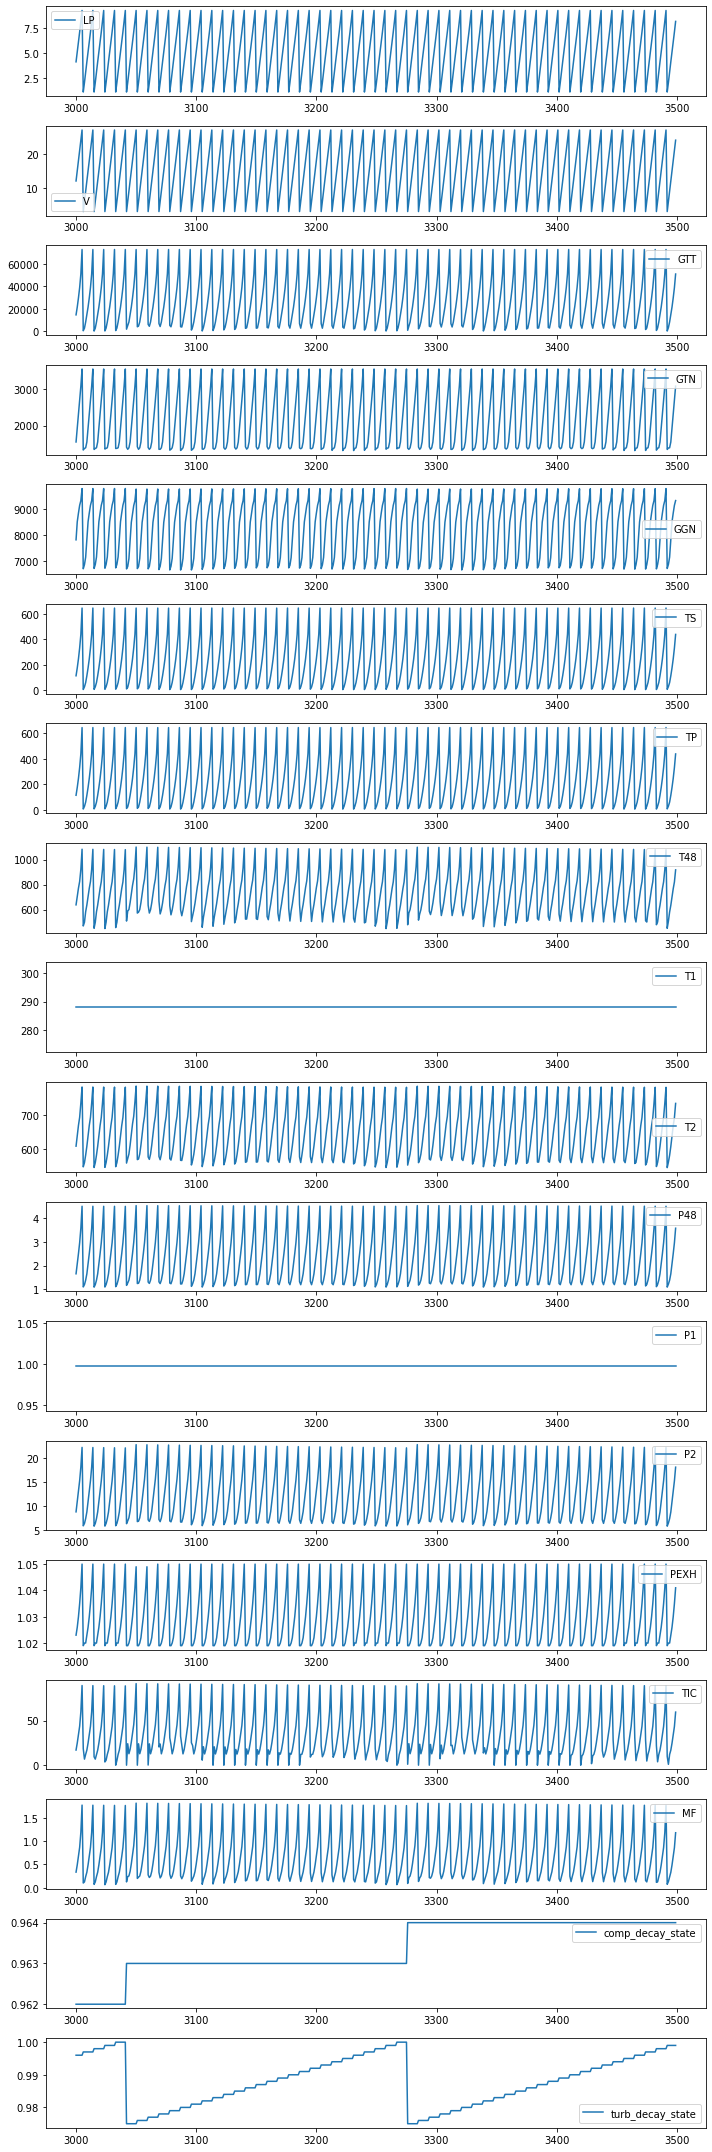

In [41]:
st = 3000
ed = 3500
fig, ax = plt.subplots(data.shape[1], figsize=(10, 30))

for i, (name, item) in enumerate(data.iteritems()):
    item.iloc[st:ed].plot(ax=ax[i], legend=True)

fig.tight_layout()


<AxesSubplot:>

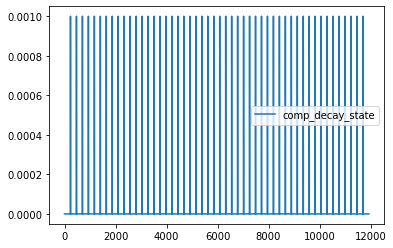

In [42]:
# data.iloc[:, -2].plot(legend=True)
data.iloc[:, -2].diff().plot(legend=True)

<AxesSubplot:>

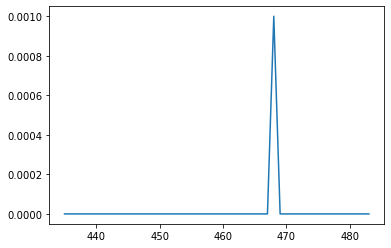

In [43]:
data.iloc[200+234:250+234, -2].diff().plot()

In [44]:
i = 5
data.iloc[:, -2].values.reshape((234, -1), order='F')

array([[0.95 , 0.951, 0.952, ..., 0.998, 0.999, 1.   ],
       [0.95 , 0.951, 0.952, ..., 0.998, 0.999, 1.   ],
       [0.95 , 0.951, 0.952, ..., 0.998, 0.999, 1.   ],
       ...,
       [0.95 , 0.951, 0.952, ..., 0.998, 0.999, 1.   ],
       [0.95 , 0.951, 0.952, ..., 0.998, 0.999, 1.   ],
       [0.95 , 0.951, 0.952, ..., 0.998, 0.999, 1.   ]])

In [94]:
def normalize(df):

    df_norm = df.copy()

    for i in range(df_norm.shape[1]):
        if df_norm.iloc[:, i].max() - df_norm.iloc[:, i].min() > 0:
            maxv = df_norm.iloc[:, i].max()
            minv = df_norm.iloc[:, i].min()
            df_norm.iloc[:, i] = (df_norm.iloc[:, i] - minv) / (maxv - minv)
        else:
            df_norm.iloc[:, i] = 0.

    return df_norm

In [110]:
data_norm = normalize(load_data('../datasets/cbm/', shorten_feature_names=False))

<AxesSubplot:>

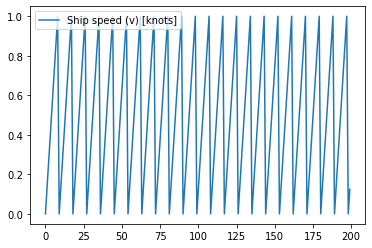

In [111]:
data_norm.iloc[:200, 1].plot(legend=True)

<AxesSubplot:>

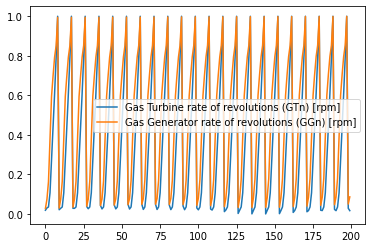

In [114]:
data_norm.iloc[:200, 3:5].plot(legend=True)

<AxesSubplot:>

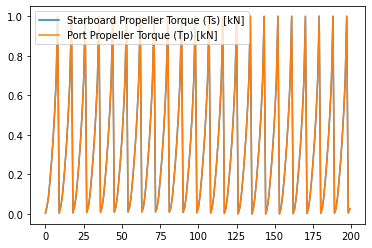

In [118]:
data_norm.iloc[:200, 5:7].plot(legend=True)

<AxesSubplot:>

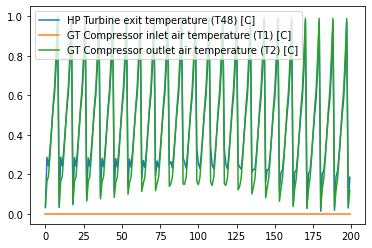

In [119]:
data_norm.iloc[:200, 7:10].plot(legend=True)

<AxesSubplot:>

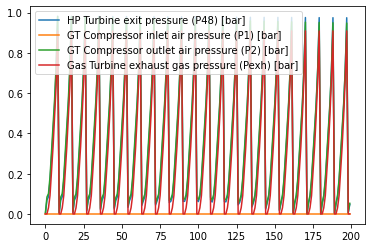

In [120]:
data_norm.iloc[:200, 10:14].plot(legend=True)

<AxesSubplot:>

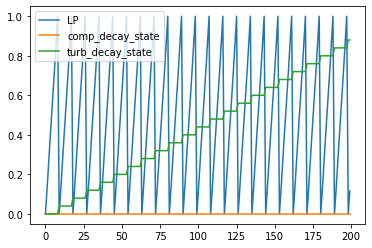

In [105]:
data_norm.iloc[:200, [0, -2, -1]].plot(legend=True)

In [146]:
def gen_summary(outdir='../out/', wd=400):

    os.makedirs(outdir, exist_ok=True)
    data = normalize(load_data('../datasets/cbm/', shorten_feature_names=False))
    
    with PdfPages(outdir + '/cbm_summary.pdf') as pp:
        for st in tqdm.trange(0, data.shape[0], wd):
            ed = st + wd
            fig, ax = plt.subplots(9, figsize=(24, 15))
            data_norm.iloc[st:ed, 1].plot(legend=True, ax=ax[0])
            data_norm.iloc[st:ed, 2].plot(legend=True, ax=ax[1])
            data_norm.iloc[st:ed, 3:5].plot(legend=True, ax=ax[2])
            data_norm.iloc[st:ed, 5:7].plot(legend=True, ax=ax[3])
            data_norm.iloc[st:ed, 7:10].plot(legend=True, ax=ax[4])
            data_norm.iloc[st:ed, 10:14].plot(legend=True, ax=ax[5])
            data_norm.iloc[st:ed, 14].plot(legend=True, ax=ax[6])
            data_norm.iloc[st:ed, 15].plot(legend=True, ax=ax[7])
            data_norm.iloc[st:ed, [0, -2, -1]].plot(legend=True, ax=ax[8])

            ax[0].set_title('Normalized Sensor/Label data')
            ax[-1].set_xlabel('Time')
            for axi in ax: axi.set_ylabel('Value')

            fig.savefig(pp, bbox_inches='tight', format='pdf')
            plt.clf()
            plt.close()

In [147]:
gen_summary()

100%|██████████| 30/30 [00:30<00:00,  1.01s/it]
